In [30]:
!pip install evaluate
warnings.filterwarnings("ignore")

# To use GPU, go to Runtime --> Change runtime type --> choose GPU

In [22]:
import torch
from transformers import AutoTokenizer
import numpy as np
from transformers import pipeline
import warnings
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
import evaluate
import pandas as pd
import datasets
from datasets import Dataset
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['label'] = train.label.replace({'positive':2,'negative':0,'neutral':1})
test['label'] = test.label.replace({'positive':2,'negative':0,'neutral':1})
df_tr, df_val = train_test_split(train, test_size=0.2)
train_dataset = Dataset.from_dict(df_tr)
val_dataset = Dataset.from_dict(df_val)
my_dataset_dict = datasets.DatasetDict({"train":train_dataset,
                                        "test":val_dataset})


In [6]:
# Every model on huggingface is defined by a unique checkpoint
# BERT
checkpoint = "bert-base-uncased"

# Tokenizer to covert text into vectors
tokenizer=AutoTokenizer.from_pretrained(checkpoint)
# Add special token to avoid errors in some models like gpt2
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Tokenize the training data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_text = my_dataset_dict.map(preprocess_function, batched=True)

# Make vectors equal in length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [7]:
# Define accuarcy to be used in fine-tuning and testing
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [8]:
# Define the LLM
# Get the sentiment in words instead of numbers
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {"negative": 0, "neutral": 1, "positive": 2}

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=3,
                                                           id2label=id2label,
                                                           label2id=label2id)
# Put the model on GPU (cuda) when available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [9]:
# Fine_Tuning

# Where the trained model will be saved
output_dir = "bert_explain"
# Hyperparameters
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_steps=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_text["train"],
    eval_dataset=tokenized_text["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics)

# Start the fine-tuning
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.716600,0.660929,0.770000
2,0.500200,0.444466,0.846667
3,0.314700,0.362356,0.873333
4,0.202700,0.337217,0.875000
5,0.176700,0.336518,0.881667


TrainOutput(global_step=375, training_loss=0.44346001116434736, metrics={'train_runtime': 429.0941, 'train_samples_per_second': 27.966, 'train_steps_per_second': 0.874, 'total_flos': 899206549674048.0, 'train_loss': 0.44346001116434736, 'epoch': 5.0})

In [27]:
# Evaluate the model on test data
def generate_predictions(model, df_test, batch_size):
    sentences = df_test.text.tolist()
    all_outputs = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        inputs = tokenizer(batch_sentences,
                           return_tensors="pt",
                           padding=True,
                           truncation=True,
                           max_length=512)

        inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            all_outputs.append(outputs['logits'])

    final_outputs = torch.cat(all_outputs, dim=0)
    df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()

# Compile the function
generate_predictions(model, test, 32)
y_pred =test['predictions']
y_test = test['label']

# Classification Report
target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.86      0.91      0.88       400
     neutral       0.86      0.79      0.82       400
    positive       0.89      0.91      0.89       400

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200



Text(0.5, 1.0, 'Confusion Matrix')

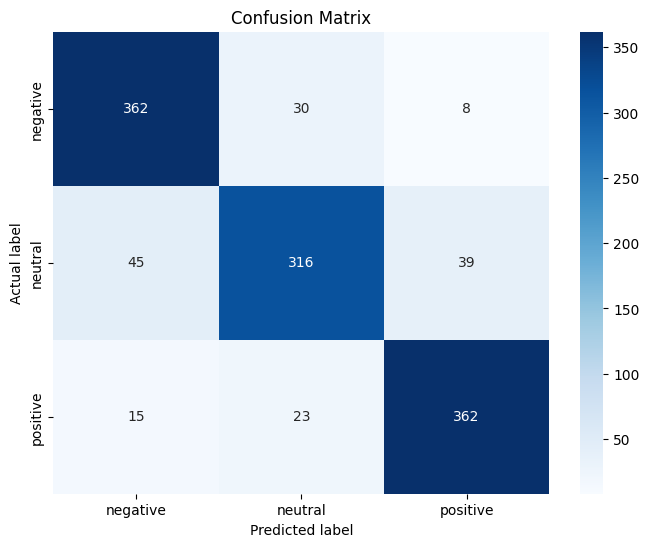

In [28]:
# Confustion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# List of the label
class_names = ['negative', 'neutral', 'positive']
# Confusion Matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix')

In [29]:
# Test a fully fine-tuned model from hugging face
checkpoint = 'kumo24/bert-sentiment-nuclear'
model_fine = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=3,
                                                           id2label=id2label,
                                                           label2id=label2id)
model_fine.to(device)
# Compile the function
generate_predictions(model_fine, test, 32)
y_pred =test['predictions']
y_test = test['label']

# Classification Report
target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.96      0.97      0.97       400
     neutral       0.94      0.97      0.95       400
    positive       0.98      0.95      0.97       400

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200

